# Barrier method

### Overview of the method

**Pseudo-code:**

Given strictly feasible $x$, $t:=t^{(0)} > 0$, $\mu > 1$, tolerance $\epsilon > 0$,

Repeat
1. Centering step: compute $x^*(t)$ by minimizing $t f_0 + \phi$, subject to $Ax=b$.
2. Update: $x:=x^*(t)$.
3. Stopping criterion: quit if $m/t \lt \epsilon$.
4. Increase $t$: $t:=\mu t$.

### Applying the barrier method to the Quadratic Problem

For implementation of log-barrier method, we consider the following problem (which is equivalent to the Quadratic Problem defined in the `readme.md`):

$$\min_{v} t(v^t Q v + p^t v) + \phi $$ 
with $\phi = -\sum_{i=1}^d \log(-Av+b)(i)$. We note $f(v)=t(v^t Q v + p^t v) + \phi$.

For the centering step of the Newton method, we compute explicitely the gradient and the Hessian matrix of $f$:
$$\nabla f(v) = t(2Qv+p) + \sum_{i=1}^d \frac{A(i)}{(-Av+b)(i)} $$ 
$$ \nabla^2 f(v) = 2tQ^t + \sum_{i=1}^d \frac{1}{(-Av+b)(i)^2}A(i)A(i)^t$$

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def f(Q, A, b, v, t0):
    """
    Implements the f function as defined above.
    """
    return t0*(np.dot(np.dot(v.T, Q), v) + np.dot(p.T, v)) - sum([np.log(-np.dot(A[i], v) + b[i]) for i in range (b.shape[0])])

def backtracking_line_search(Q, p, v, t, grad_f, newton_step, t0):
    """
    Backtracking line search.
    """
    if (-A.dot(v + t*newton_step) + b>0).all() and f(Q, A, b, v + t*newton_step, t0) <= (f(Q, A, b, v, t0) + alpha*t*np.dot(grad_f.T, newton_step)):
        return v + t*newton_step
    else: 
        return backtracking_line_search(Q, p, v, beta*t, grad_f, newton_step, t0)

def centering_step(Q, p, A, b, t, v0, eps=10e-6, n_it_centering=0):
    """
    Implements the barrier method's centering step.
    """
    V = []
    d, n = np.shape(A)
    
    # computing the gradient of f
    C = -np.dot(A, v0)+b
    B = np.array([[A[i,k]/C[i] for k in range(n)] for i in range(d)])
    grad_f = t*(2*np.dot(Q, v0)+p) + np.sum(B, axis=0)
    
    # computing the hessian matrix
    B1 = [np.dot(A[i,:], np.matrix.transpose(A[i,:]))/(C[i]**2) for i in range(d)]
    hess_f = t*2*np.matrix.transpose(Q) + np.sum(B1)
        
    newton_step = -np.dot(np.linalg.inv(hess_f), grad_f)
    decrement2 = np.dot(grad_f.T, np.dot(np.linalg.inv(hess_f), grad_f))
    
    # stopping criterion
    if decrement2/2 <= eps:
        return v0, n_it_centering
    
    v1 = backtracking_line_search(Q, p, v0, 1, grad_f, newton_step, t)
    return centering_step(Q, p, A, b, t, v1, eps, n_it_centering+1)

def barr_method(Q, p, A, b, v0, eps=10e-6, mu=5):
    t = 1
    v = v0
    d, n = np.shape(A)
    n_it, v_seq, n_it_value = [0], [v0], 0
    
    for _ in range(1000): # max it allowed
        # centering step
        v, n_it_centering = centering_step(Q, p, A, b, t, v, eps)
        n_it_value += n_it_centering
        n_it.append(n_it_value)
        v_seq.append(v)
        
        # stopping criterion
        if d/t < eps:
            return v, n_it, v_seq
        
        # increase t
        t = mu*t
    return v, n_it, v_seq

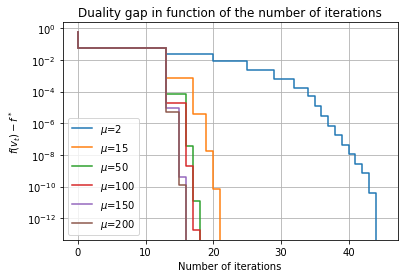

In [10]:
alpha, beta = 0.1, 0.7
n, d = 5, 30 
eps = 10e-6
lamb = 10

X = np.random.rand(n,d)
y = np.random.rand(n,1)

Q = 0.5*np.eye(n)
p = -y
A = np.vstack((X.T,-X.T))
b = lamb*np.ones((2*d,1))

v0 = np.zeros((n,1))

fig, ax = plt.subplots()
mu_list = [2, 15, 50, 100, 150, 200]
for mu in mu_list:
    v_center, n_it_seq, v_seq = barr_method(Q, p, A, b, v0, eps=10e-6, mu=mu)
    f_found = [float((np.dot(v.T, np.dot(Q, v)) + np.dot(p.T, v))[0]) for v in v_seq]
    ax.step(n_it_seq, np.array(f_found) - f_found[-1], label=fr"$\mu$={mu}")


ax.set_xlabel("Number of iterations")
ax.set_ylabel(r"$f(v_t) - f^*$")
ax.set_yscale("log")
ax.set_title("Duality gap in function of the number of iterations")

plt.legend()
plt.grid()
plt.show()

The higher $\mu$, the less iterations are necessary to converge.